In [1]:
import numpy as np
import matplotlib.pylab as plt
import time
from helper import get_clean_project_name
from pyiron_atomistics import Project
from pyiron_atomistics.atomistics.structure.atoms import ase_to_pyiron, pyiron_to_ase
import pyiron_gpl
import seaborn as sns
import pandas as pd
from pychromatic import Multiplot
from pychromatic.colors import accent
from scipy.optimize import curve_fit
colors = {"g": "#1b9e77", "r": "#d95f02", "b": "#7570b3"}

/home/menon/miniconda3/envs/potentials2023/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
pr = Project("validation_LiAl2")

In [9]:
list_of_phases = ["Al_fcc","Li_bcc","Li2Al2_cubic","LiAl3_cubic"]

In [10]:
def filter_elastic(job_table):
    return (job_table.hamilton == "ElasticMatrixJob") & (job_table.status == "finished")

# Get corresponding elastic constants
def get_c11(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 0]

def get_c12(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 1]

def get_c44(job_path):
    return job_path["output/elasticmatrix"]["C"][3, 3]

def get_potential(job_path):
    return job_path.project.path.split("/")[-2]

def get_crystal_structure(job_path):
    return job_path.job_name.split("_")[-1]

def get_compound(job_path):
    return job_path.job_name.split("_")[-2]

In [11]:
table = pr.create_table("table_elastic", delete_existing_job=True)
table.db_filter_function = filter_elastic
table.add["potential"] = get_potential
table.add["C11"] = get_c11
table.add["C12"] = get_c12
table.add["C44"] = get_c44
table.add["compound"] = get_compound
table.add["crystal_structure"] = get_crystal_structure

table.run()
data_elastic = table.get_dataframe()
data_elastic["phase"] = data_elastic.compound + "_" + data_elastic.crystal_structure
data_elastic = data_elastic[data_elastic["phase"].isin(list_of_phases)]
data_elastic

The job table_elastic was saved and received the ID: 2086


Loading and filtering jobs:   0%|          | 0/12 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/12 [00:00<?, ?it/s]

,job_id,potential,C11,C12,C44,compound,crystal_structure,phase
0,1875,AlLi_eam,98.072058,66.458423,46.128769,Al,fcc,Al_fcc
1,1891,AlLi_eam,14.905778,14.365771,11.504125,Li,bcc,Li_bcc
2,1907,AlLi_eam,130.928772,50.341046,25.279659,Li2Al2,cubic,Li2Al2_cubic
3,1924,AlLi_eam,97.232783,67.752767,22.146522,LiAl3,cubic,LiAl3_cubic
4,1941,AlLi_hdnnp,131.078962,67.060904,48.627761,Al,fcc,Al_fcc
5,1957,AlLi_hdnnp,11.788102,13.454052,12.623277,Li,bcc,Li_bcc
6,1973,AlLi_hdnnp,119.859227,20.487189,41.936676,Li2Al2,cubic,Li2Al2_cubic
7,1990,AlLi_hdnnp,109.832419,44.780823,43.105017,LiAl3,cubic,LiAl3_cubic
8,2007,AlLi_ace,130.390756,61.022690,39.354664,Al,fcc,Al_fcc
9,2023,AlLi_ace,13.107614,12.416830,10.918415,Li,bcc,Li_bcc


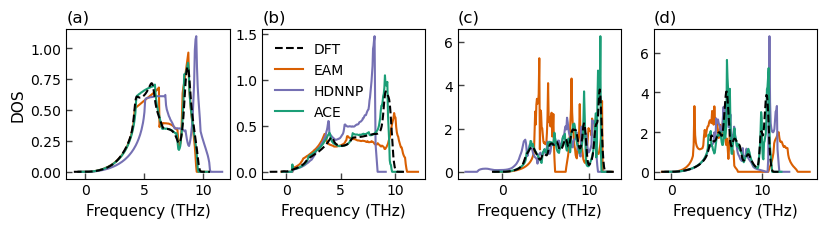

In [15]:
mlt = Multiplot(columns=4, rows=1, width=700, ratio=0.2, )#wspace=0.3)


phase = 'Al_fcc'
data = data_elastic[(data_elastic.phase == phase)]
dft_ref = pd.read_csv(phase.lower()+"_dos.csv")
mlt[0,0].plot(dft_ref["dos_energy"],dft_ref["dos_total"],ls="--",lw=1.5,color='black',label="DFT",zorder=10)

pot = 'AlLi_eam'
phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
mlt[0,0].plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
        lw=1.5,
        color=colors["r"], 
        label='EAM')

pot = 'AlLi_hdnnp'
phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
mlt[0,0].plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
        lw=1.5,
        color=colors["b"], 
        label='HDNNP')

pot = 'AlLi_ace'
phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
mlt[0,0].plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
        lw=1.5,
        color=colors["g"], 
        label='ACE')

mlt[0,0].set_ylabel("DOS",fontsize=11)
mlt[0,0].set_title("(a)", loc='left', fontsize=12)
mlt[0,0].set_xlabel("Frequency (THz)",fontsize=11)

phase = 'Li_bcc'
data = data_elastic[(data_elastic.phase == phase)]
dft_ref = pd.read_csv(phase.lower()+"_dos.csv")
mlt[0,1].plot(dft_ref["dos_energy"],dft_ref["dos_total"],ls="--",lw=1.5,color='black',label="DFT", zorder=10)

pot = 'AlLi_eam'
phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
mlt[0,1].plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
        lw=1.5,
        color=colors["r"], 
        label='EAM')
pot = 'AlLi_hdnnp'
phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
mlt[0,1].plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
        lw=1.5,
        color=colors["b"], 
        label='HDNNP')
pot = 'AlLi_ace'
phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
mlt[0,1].plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
        lw=1.5,
        color=colors["g"], 
        label='ACE')
mlt[0,1].set_title("(b)", loc='left', fontsize=12)
mlt[0,1].set_xlabel("Frequency (THz)",fontsize=11)
mlt[0,1].legend(frameon=False)


phase = 'Li2Al2_cubic'
data = data_elastic[(data_elastic.phase == phase)]
dft_ref = pd.read_csv(phase.lower()+"_dos.csv")
mlt[0,2].plot(dft_ref["dos_energy"],dft_ref["dos_total"],ls="--",lw=1.5,color='black',label="DFT",zorder=10)

pot = 'AlLi_eam'
phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
mlt[0,2].plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
        lw=1.5,
        color=colors["r"], 
        label='EAM')
pot = 'AlLi_hdnnp'
phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
mlt[0,2].plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
        lw=1.5,
        color=colors["b"], 
        label='HDNNP')
pot = 'AlLi_ace'
phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
mlt[0,2].plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
        lw=1.5,
        color=colors["g"], 
        label='ACE')

#mlt[0,2].set_ylabel("DOS",fontsize=11)
mlt[0,2].set_title("(c)", loc='left', fontsize=12)
mlt[0,2].set_xlabel("Frequency (THz)",fontsize=11)


phase = 'LiAl3_cubic'
data = data_elastic[(data_elastic.phase == phase)]
dft_ref = pd.read_csv(phase.lower()+"_dos.csv")
mlt[0,3].plot(dft_ref["dos_energy"],dft_ref["dos_total"],ls="--",lw=1.5,color='black',label="DFT", zorder=10)

pot = 'AlLi_eam'
phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
mlt[0,3].plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
        lw=1.5,
        color=colors["r"], 
        label='EAM')
pot = 'AlLi_hdnnp'
phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
mlt[0,3].plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
        lw=1.5,
        color=colors["b"], 
        label='HDNNP')
pot = 'AlLi_ace'
phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
mlt[0,3].plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
        lw=1.5,
        color=colors["g"], 
        label='ACE')

mlt[0,3].set_title("(d)", loc='left', fontsize=12)
mlt[0,3].set_xlabel("Frequency (THz)",fontsize=11)
plt.savefig("img_dos.png", dpi=300, bbox_inches='tight')